# Modelos de regresión

In [3]:
!pip install gpboost
!pip install shap
!pip install xgboost
!pip install geopandas

     |████████████████████████████████| 1.0 MB 28.2 MB/s 
     |████████████████████████████████| 6.3 MB 63.3 MB/s 
     |████████████████████████████████| 15.4 MB 29.9 MB/s 


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import wkt

# Modelos
import gpboost as gpb
import shap
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


## Lectura de datos 

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/alessiobocco/Diplo_Eco/main/data/modelling_data.csv',  index_col=[0])

In [6]:
data.head()

,id,antig,m2total,m2cub,ambientes,banios,precioUSD,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_gastronomia,lon_planar,lat_planar,densidad_poblacional,densidad_viviendas,poi_count_gastronomia,poi_count_educacion,poi_count_roads,poi_count_salud,poi_count_transporte,cardinality,m2total_buffer_500,m2total_buffer_1000,clusters,comunas_1,comunas_10,comunas_11,comunas_12,comunas_13,comunas_14,comunas_15,comunas_2,comunas_3,comunas_4,comunas_5,comunas_6,comunas_7,comunas_8,...,barrios_SAN NICOLAS,barrios_SAN TELMO,barrios_VELEZ SARSFIELD,barrios_VERSALLES,barrios_VILLA CRESPO,barrios_VILLA DEL PARQUE,barrios_VILLA DEVOTO,barrios_VILLA GRAL. MITRE,barrios_VILLA LUGANO,barrios_VILLA LURO,barrios_VILLA ORTUZAR,barrios_VILLA PUEYRREDON,barrios_VILLA REAL,barrios_VILLA RIACHUELO,barrios_VILLA SANTA RITA,barrios_VILLA SOLDATI,barrios_VILLA URQUIZA,distritos_DISTRITO AUDIOVISUAL,distritos_DISTRITO DE DISEÑO,distritos_DISTRITO DE LAS ARTES,distritos_DISTRITO DEL DEPORTE,distritos_DISTRITO TECNOLOGICO,distritos_NO CARACTERIZADO,SobreAvenida_0,SobreAvenida_1,Aestrenar_0,Aestrenar_1,monoambiente_0,monoambiente_1,clas_ambientes_0,clas_ambientes_1,clas_ambientes_2,clas_ambientes_3,clas_ambientes_4,clas_ambientes_5,clas_banios_0,clas_banios_1,clas_banios_2,clas_banios_3,clas_banios_4
0,1,0,200,200,0,0,1500000,7500.000000,1162.621600,14053.797191,134,68426.445,12,-6.515379e+06,-4.114971e+06,9162.535077,3428.444997,52.0,16.0,7.0,6.0,2.0,8,126.750000,321.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0
1,2,30,50,50,0,1,125000,2500.000000,1887.227055,13473.139375,23,110997.543,3,-6.515323e+06,-4.111252e+06,8847.779056,3215.839159,6.0,0.0,10.0,1.0,0.0,1,50.000000,179.000000,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0
2,3,30,414,414,0,2,590000,1425.120773,1497.020434,13514.662463,33,115341.039,5,-6.515320e+06,-4.111882e+06,8773.980909,3209.091367,4.0,3.0,9.0,2.0,0.0,6,207.666667,231.111111,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
3,4,35,414,414,0,2,730000,1763.000000,1506.066814,13495.631683,33,115500.289,5,-6.515298e+06,-4.111865e+06,8773.980909,3209.091367,7.0,3.0,10.0,2.0,0.0,5,192.200000,231.111111,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
4,5,35,285,285,0,1,550000,1929.000000,1506.066814,13495.631683,33,115500.289,5,-6.515298e+06,-4.111865e+06,8773.980909,3209.091367,7.0,3.0,10.0,2.0,0.0,5,192.200000,231.111111,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0


In [7]:
y = data.precioUSD
X = data.drop("precioUSD", axis = 1)

In [8]:
X.head()

,id,antig,m2total,m2cub,ambientes,banios,m2precioUSD,comisaria_dista,obelisco_dista,nrobos,sup_espacio_verde,count_gastronomia,lon_planar,lat_planar,densidad_poblacional,densidad_viviendas,poi_count_gastronomia,poi_count_educacion,poi_count_roads,poi_count_salud,poi_count_transporte,cardinality,m2total_buffer_500,m2total_buffer_1000,clusters,comunas_1,comunas_10,comunas_11,comunas_12,comunas_13,comunas_14,comunas_15,comunas_2,comunas_3,comunas_4,comunas_5,comunas_6,comunas_7,comunas_8,comunas_9,...,barrios_SAN NICOLAS,barrios_SAN TELMO,barrios_VELEZ SARSFIELD,barrios_VERSALLES,barrios_VILLA CRESPO,barrios_VILLA DEL PARQUE,barrios_VILLA DEVOTO,barrios_VILLA GRAL. MITRE,barrios_VILLA LUGANO,barrios_VILLA LURO,barrios_VILLA ORTUZAR,barrios_VILLA PUEYRREDON,barrios_VILLA REAL,barrios_VILLA RIACHUELO,barrios_VILLA SANTA RITA,barrios_VILLA SOLDATI,barrios_VILLA URQUIZA,distritos_DISTRITO AUDIOVISUAL,distritos_DISTRITO DE DISEÑO,distritos_DISTRITO DE LAS ARTES,distritos_DISTRITO DEL DEPORTE,distritos_DISTRITO TECNOLOGICO,distritos_NO CARACTERIZADO,SobreAvenida_0,SobreAvenida_1,Aestrenar_0,Aestrenar_1,monoambiente_0,monoambiente_1,clas_ambientes_0,clas_ambientes_1,clas_ambientes_2,clas_ambientes_3,clas_ambientes_4,clas_ambientes_5,clas_banios_0,clas_banios_1,clas_banios_2,clas_banios_3,clas_banios_4
0,1,0,200,200,0,0,7500.000000,1162.621600,14053.797191,134,68426.445,12,-6.515379e+06,-4.114971e+06,9162.535077,3428.444997,52.0,16.0,7.0,6.0,2.0,8,126.750000,321.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0
1,2,30,50,50,0,1,2500.000000,1887.227055,13473.139375,23,110997.543,3,-6.515323e+06,-4.111252e+06,8847.779056,3215.839159,6.0,0.0,10.0,1.0,0.0,1,50.000000,179.000000,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0
2,3,30,414,414,0,2,1425.120773,1497.020434,13514.662463,33,115341.039,5,-6.515320e+06,-4.111882e+06,8773.980909,3209.091367,4.0,3.0,9.0,2.0,0.0,6,207.666667,231.111111,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
3,4,35,414,414,0,2,1763.000000,1506.066814,13495.631683,33,115500.289,5,-6.515298e+06,-4.111865e+06,8773.980909,3209.091367,7.0,3.0,10.0,2.0,0.0,5,192.200000,231.111111,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
4,5,35,285,285,0,1,1929.000000,1506.066814,13495.631683,33,115500.289,5,-6.515298e+06,-4.111865e+06,8773.980909,3209.091367,7.0,3.0,10.0,2.0,0.0,5,192.200000,231.111111,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.33, random_state=42)

coords_train = X_train[['lon_planar', 'lat_planar']]
coords_test = X_test[['lon_planar', 'lat_planar']]

In [16]:
features = ['id', 'lon_planar', 'lat_planar', 'banios', 'ambientes']

In [17]:
X_train = X_train.drop(features, axis = 1)
X_test = X_test.drop(features, axis = 1)

In [18]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

## Aplicamos la transformación de escala sobre los features
scaler_X.fit(X_train)
X_scaled_train = scaler_X.transform(X_train)
X_scaled_test  = scaler_X.transform(X_test)

## Aplicamos la transformación de escala sobre la variable objetivo
## Observación: StandardScaler toma como input una matriz. Si queremos darle un
## vector (como por ej. para utilizar con la variable objetivo), tenemos que 
## transformar ese vector en una matriz de una sola columna. Esto lo hacemos
## con el método 'reshape'
scaler_y.fit(y_train.values.reshape(-1, 1))
y_scaled_train = scaler_y.transform(y_train.values.reshape(-1, 1))[:,0]
y_scaled_test  = scaler_y.transform(y_test.values.reshape(-1, 1))[:,0]

In [19]:
gp_model = gpb.GPModel(gp_coords = coords_train, cov_function="exponential")
data_train = gpb.Dataset(X_train, y_train)
params = { 'objective': 'regression_l2', 'verbose': 0 }
# Training
bst = gpb.train(params=params, train_set=data_train,
                gp_model=gp_model, num_boost_round=247)
gp_model.summary() # Estimated covariance parameters
# Prediction
pred = bst.predict(data=X_test, gp_coords_pred=coords_test,
                    predict_var=True)
# Sum the predictions of the trees and the GP
y_pred = pred['fixed_effect'] + pred['random_effect_mean']

[GPBoost] [Warning] Find whitespaces in feature_names, replace with underlines
Covariance parameters 
['Error_term', 'GP_var', 'GP_range']
[1.96807923e+10 1.90227881e+11 2.71014487e+01]


In [20]:
## Utilizaremos la raiz cuadrada del error cuadrático medio como 
## medida del error
def rmse(y1, y2):
    """
    Raiz cuadrada del error cuadrático medio.
    """
    return np.sqrt(mean_squared_error(y1, y2))

In [21]:
from sklearn.metrics import mean_squared_error

In [23]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_test  = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

In [24]:
rmse(y_test, pred_test)

211845016809.0451

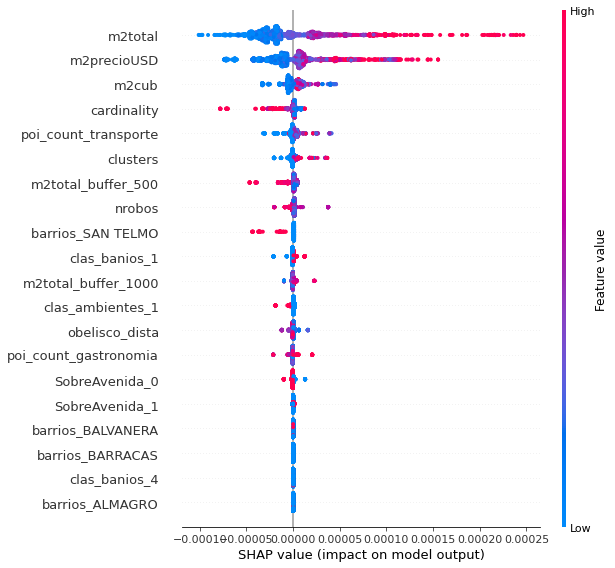

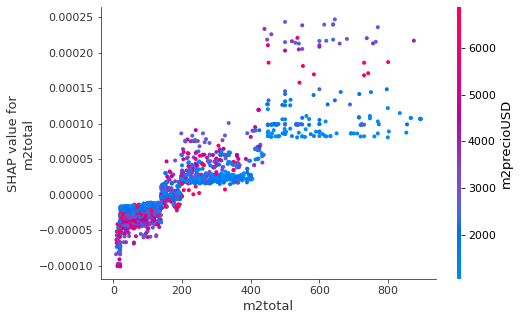

In [25]:
shap_values = shap.TreeExplainer(bst).shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.dependence_plot("m2total", shap_values, X_train)

In [ ]:
# --------------------Parameter tuning using a validation set----------------
# Define training and validation data by setting indices of 'folds'
n = len(X_train_
permut = np.random.RandomState(10).choice(a=n, size=n, replace=False)
train_idx = permut[0:int(n/2)]
valid_idx = permut[int(n/2):n]
folds = [(train_idx, valid_idx)]
# Parameter tuning using validation data
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid_small,
                                             params=params,
                                             folds=folds,
                                             gp_model=gp_model,
                                             use_gp_model_for_validation=True,
                                             train_set=data_train,
                                             verbose_eval=1,
                                             num_boost_round=1000, 
                                             early_stopping_rounds=10,
                                             seed=1000,
                                             metrics='binary_logloss')
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

## XGBoost

In [27]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [28]:
# import packages for hyperparameters tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error
import time

In [29]:
# Definicion de la funcion de pérdida del RMSE
def RMSLE(y, y_pred):
    """ 
    Función de costo del rmse
    """
    return (np.sqrt(mean_squared_error(y, y_pred)))

# Definicion del scoring para usar en la validación
rmsle_loss = make_scorer(RMSLE, greater_is_better=False)

In [30]:
param_grid={"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "min_child_weight" : [ 1, 3, 5, 7 ],
             "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

model = xg.XGBRegressor()


In [33]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring=rmsle_loss, cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 0, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer).reshape(-1, 1))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer).reshape(-1, 1))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer.reshape(-1, 1))
    test_rescaled  = scaler_y.inverse_transform(y_test_outer.reshape(-1, 1))
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

[20:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=47549.432, RMSE_test=69666.861 score = -0.266, param = {'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.7}
La iteración tomó 244.977 segundos.
[20:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=38348.635, RMSE_test=134892.554 score = -0.249, param = {'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.0, 'colsample_bytree': 0.7}
La iteración tomó 224.458 segundos.
[20:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
>RMSE_train=59685.454, RMSE_test=104860.885 score = -0.275, param = {'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
La iteración tomó 256.906 segundos.
[20:

In [34]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

[20:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.15,
             min_child_weight=5)

In [36]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train).reshape(-1, 1))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test).reshape(-1, 1))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Train RMSE: 49842.99208953134
Test RMSE: 144095.33213447925


## Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor()


In [ ]:
# Configuración de la validación cruzada anidada
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# Iterar por las divisiones del dataset original
rmse_train_results = list() # Guardar el error de train
rmse_test_results = list() # Guardar el error de test
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(X_scaled_train):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_test_outer = X_scaled_train[train_ix, :], X_scaled_train[test_ix, :]
    y_train_outer, y_test_outer = y_scaled_train[train_ix], y_scaled_train[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = KFold(n_splits=10, shuffle=True, random_state=1)

    # Definir la busqueda
    search = RandomizedSearchCV(model, param_grid, scoring=rmsle_loss, cv=cv_inner, n_iter = 100,
                                refit=True, verbose = 0, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = scaler_y.inverse_transform(best_model_iteration.predict(X_train_outer).reshape(-1, 1))
    pred_test  = scaler_y.inverse_transform(best_model_iteration.predict(X_test_outer).reshape(-1, 1))
    # Convertir la variable objetivo a su escala original
    train_rescaled = scaler_y.inverse_transform(y_train_outer.reshape(-1, 1))
    test_rescaled  = scaler_y.inverse_transform(y_test_outer.reshape(-1, 1))
    # Calcular métricas de error
    train_rmse_values = RMSLE(pred_train, train_rescaled)
    test_rmse_values = RMSLE(pred_test, test_rescaled)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > test_rmse_values:
        best_model = result.best_estimator_
        best_score = test_rmse_values
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmse_values)
    rmse_test_results.append(test_rmse_values)
    # Reporte de progreso
    print('>RMSE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, test_rmse_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSE_train: %.3f (%.3f)' % (np.mean(rmse_train_results), np.std(rmse_train_results)))
print('RMSE_test: %.3f (%.3f)' % (np.mean(rmse_test_results), np.std(rmse_test_results)))

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [ ]:
# Ajustar el modelo con todos los datos
best_model.fit(X_scaled_train, y_scaled_train)

In [ ]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = scaler_y.inverse_transform(best_model.predict(X_scaled_train).reshape(-1, 1))
pred_test  = scaler_y.inverse_transform(best_model.predict(X_scaled_test).reshape(-1, 1))

print('Train RMSE:', RMSLE(pred_train, y_train))
print('Test RMSE:', RMSLE(pred_test, y_test))

Feature importance

In [ ]:
train_features = list(X_train.columns)

In [ ]:
base_imp = imp_df(train_features, best_model.feature_importances_)
base_imp

In [ ]:
var_imp_plot(base_imp, 'Importancia de cada feature')